In [ ]:
# default_exp postprocessing

Module Postprocessing
---

Nipype interfaces for generating connectomes after pre-processing of DWI and `.trk` generation.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti

import os

from nipype import IdentityInterface
from nipype.pipeline import Node, Workflow
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, File, TraitedSpec, traits
from nipype.interfaces.mrtrix3.connectivity import LabelConvert
from nipype.interfaces.mrtrix3.utils import Generate5tt
from nipype.interfaces.mrtrix3.preprocess import ResponseSD
from nipype.interfaces.mrtrix3.reconst import EstimateFOD, ConstrainedSphericalDeconvolution
from nipype.interfaces import ants

201006-09:29:40,374 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


### Atlas files input:

Use `IdentityInterface` as a node for atlas inputs. Atlas inputs as a list if constructing multiple connnectomes. Look-up tables should also be an input. 

https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html

In [ ]:
#example
#usage

atlas_dir = '/Users/xxie/lab/Human_Brain_Atlases'  # needs to be defined... either as an user input or pre-defined BIDS dir
atlas_list = ['brainnectome', 'desikan-killiany']  # probably an input as well, currently have LUT corrected images for desikan-killiany, brainnectome, aal

# Node for IdentityInterface
atlas_source = Node(IdentityInterface(fields = ['atlas_name']), 
                    name = 'atlas_source')
atlas_source.iterables = [('atlas_name', atlas_list)]  # iterate over atlas input names

# Node for select files: actually selecting files
atlas_template = {
    'atlases': os.path.join(
        atlas_dir, '{atlas_name}', '*_1mm.nii.gz' 
    )
}
atlas_file = Node(
    SelectFiles(atlas_template),
    base_directory=atlas_dir,
    name='select_atlas'
)

# Create datasink for selected files
datasink = Node(DataSink(base_directory = '/Users/xxie/lab/pipetography/outputs',
               container='datasink'),
                name='datasink')

wf_atlas = Workflow(name="choose_atlas")
wf_atlas.connect(atlas_source, 'atlas_name', atlas_file, 'atlas_name')
wf_atlas.connect(atlas_file, 'atlases', datasink, 'atlases')
wf_atlas.run()

! ls -lh /Users/xxie/lab/pipetography/outputs/datasink/atlases/

201001-10:14:41,949 nipype.workflow INFO:
	 Workflow choose_atlas settings: ['check', 'execution', 'logging', 'monitoring']
201001-10:14:41,960 nipype.workflow INFO:
	 Running serially.
201001-10:14:41,961 nipype.workflow INFO:
	 [Node] Setting-up "choose_atlas.select_atlas" in "/private/var/folders/26/ys2mhp6j58n047rd6tvx76sm0000gp/T/tmpwdjftgxd/choose_atlas/_atlas_name_desikan-killiany/select_atlas".
201001-10:14:41,966 nipype.workflow INFO:
	 [Node] Running "select_atlas" ("nipype.interfaces.io.SelectFiles")
201001-10:14:41,972 nipype.workflow INFO:
	 [Node] Finished "choose_atlas.select_atlas".
201001-10:14:41,973 nipype.workflow INFO:
	 [Node] Setting-up "choose_atlas.datasink" in "/private/var/folders/26/ys2mhp6j58n047rd6tvx76sm0000gp/T/tmp_gqjektk/choose_atlas/_atlas_name_desikan-killiany/datasink".
201001-10:14:41,980 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201001-10:14:41,989 nipype.workflow INFO:
	 [Node] Finished "choose_atlas.data

### Subject files input:

Tracts `.tck` files input (need to convert from trk to tck if using NVIDIA cuda, currently included in shell script attached to NVIDIA singularity).

Whole brain volume `T1.mgz` files input, these are outputs of freesurfer's `recon-all`, subsequently used to generate tissue segmented files. 

In [ ]:
data_dir = '/Users/xxie/sample_data/dwipreproc'
session_id = '002'
subject_id = '01'

subj_source = Node(IdentityInterface(fields=["subject_id", "session_id"]), name = 'subj_source')
subj_template = {
    'tck': os.path.join(data_dir, 'cuda_tracking', '_session_id_{session_id}_subject_id_{subject_id}', 'sub-{subject_id}_ses-{session_id}.tck'),
    'dwi': os.path.join(data_dir, 'derivatives', 'dwi_acpc_aligned_1mm', '_session_id_{session_id}_subject_id_{subject_id}', 'dwi_acpc_1mm.mif'),
    'acpcT1':  os.path.join(data_dir, 'derivatives', 't1_acpc_aligned', '_session_id_{session_id}_subject_id_{subject_id}', 'acpc_t1.nii')
}
subj_source.inputs.subject_id = subject_id
subj_source.inputs.session_id = session_id

201001-11:20:16,355 nipype.workflow INFO:
	 [Node] Setting-up "subj_source" in "/private/var/folders/26/ys2mhp6j58n047rd6tvx76sm0000gp/T/tmpd8y9s0wa/subj_source".
201001-11:20:16,360 nipype.workflow INFO:
	 [Node] Running "subj_source" ("nipype.interfaces.utility.base.IdentityInterface")
201001-11:20:16,365 nipype.workflow INFO:
	 [Node] Finished "subj_source".



session_id = 002
subject_id = 01

### ANTS Registration

Align atlases to DWI images

In [ ]:
#example
#usage

linear_reg = ants.Registration()
# Registration inputs:
linear_reg.inputs.moving_image = '/Users/xxie/lab/pipetography/outputs/datasink/atlases/DK_Atlas_86_1mm.nii.gz' # need DIR to atlas
linear_reg.inputs.fixed_image = '/Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_brain.nii.gz'  # Path to DWI brain
linear_reg.inputs.output_transform_prefix = 'atlas_in_dwi_affine'
linear_reg.inputs.dimension = 3 #-d
# -tranform
linear_reg.inputs.collapse_output_transforms = True # -z flag
linear_reg.inputs.transforms = ['Affine']
linear_reg.inputs.transform_parameters=[(0.1,)]
# -metric
linear_reg.inputs.metric = ['MI']
linear_reg.inputs.metric_weight = [1] #default, value ignored by ANTS
linear_reg.inputs.radius_or_number_of_bins = [64]
# -convergence
linear_reg.inputs.number_of_iterations = [[500,200,200,100]]
linear_reg.inputs.convergence_threshold = [1e-06]
linear_reg.inputs.convergence_window_size = [10]
# -s
linear_reg.inputs.smoothing_sigmas = [[4,2,1,0]]
linear_reg.inputs.sigma_units = ['vox']
# -f
linear_reg.inputs.shrink_factors = [[8,4,2,1]]
linear_reg.inputs.use_histogram_matching = [True] # -u flag
linear_reg.inputs.output_warped_image = 'atlas_in_dwi_affine.nii.gz'

# print command:
linear_reg.cmdline

# run:
#linear_reg.run()

'antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output [ atlas_in_dwi_affine, atlas_in_dwi_affine.nii.gz ] --transform Affine[ 0.1 ] --metric MI[ /Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_brain.nii.gz, /Users/xxie/lab/pipetography/outputs/datasink/atlases/DK_Atlas_86_1mm.nii.gz, 1, 64 ] --convergence [ 500x200x200x100, 1e-06, 10 ] --smoothing-sigmas 4.0x2.0x1.0x0.0vox --shrink-factors 8x4x2x1 --use-histogram-matching 1 --winsorize-image-intensities [ 0.0, 1.0 ]  --write-composite-transform 0'

In [ ]:
#example
#usage

#### additional nonlinear registration node:
syn_reg = ants.Registration()
# Registration inputs:
syn_reg.inputs.moving_image = 'atlas_in_dwi_affine.nii.gz' # need DIR to atlas
syn_reg.inputs.fixed_image = '/Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_brain.nii.gz'  # Path to DWI brain
syn_reg.inputs.output_transform_prefix = 'atlas_in_dwi_syn'
syn_reg.inputs.dimension = 3 #-d
# -tranform
syn_reg.inputs.collapse_output_transforms = True # -z flag
syn_reg.inputs.transforms = ['SyN']
syn_reg.inputs.transform_parameters=[(0.1,)]
# -metric
syn_reg.inputs.metric = ['MI']
syn_reg.inputs.metric_weight = [1] #default, value ignored by ANTS
syn_reg.inputs.radius_or_number_of_bins = [64]
# -convergence
syn_reg.inputs.number_of_iterations = [[500,200,200,100]]
syn_reg.inputs.convergence_threshold = [1e-06]
syn_reg.inputs.convergence_window_size = [10]
# -s
syn_reg.inputs.smoothing_sigmas = [[4,2,1,0]]
syn_reg.inputs.sigma_units = ['vox']
# -f
syn_reg.inputs.shrink_factors = [[8,4,2,1]]
syn_reg.inputs.use_histogram_matching = [True] # -u flag
syn_reg.inputs.output_warped_image = 'atlas_in_dwi_syn.nii.gz'

# print command
print(syn_reg.cmdline)

# run:
syn_reg.run()

antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output [ atlas_in_dwi_syn, atlas_in_dwi_syn.nii.gz ] --transform SyN[ 0.1 ] --metric MI[ /Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_brain.nii.gz, atlas_in_dwi_affine.nii.gz, 1, 64 ] --convergence [ 500x200x200x100, 1e-06, 10 ] --smoothing-sigmas 4.0x2.0x1.0x0.0vox --shrink-factors 8x4x2x1 --use-histogram-matching 1 --winsorize-image-intensities [ 0.0, 1.0 ]  --write-composite-transform 0


### FOD Modeling

Create white matter fiber orientation image. First use `dwi2response dhollander` to generate white matter, grey matter, and CSF spherical deconvolution response files, then use `dwi2fod msmt_csd` with a tissue response function input to generate FODs for the white matter, gray matter, and CSF.

In [ ]:
#example
#usage

#dwi2response
dwi_resp = ResponseSD()
dwi_resp.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_002_subject_id_01/dwi_acpc_1mm.mif'  # input DWI.mif
dwi_resp.inputs.algorithm = 'dhollander'  # choose between dhollander
dwi_resp.inputs.wm_file = 'outputs/wm.txt'
dwi_resp.inputs.gm_file = 'outputs/gm.txt'
dwi_resp.inputs.csf_file = 'outputs/csf.txt'
print(dwi_resp.cmdline)
dwi_resp.run()

dwi2response dhollander /Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_002_subject_id_01/dwi_acpc_1mm.mif outputs/wm.txt outputs/gm.txt outputs/csf.txt
201001-12:50:17,695 nipype.interface INFO:
	 stderr 2020-10-01T12:50:17.694795:dwi2response: 
201001-12:50:17,697 nipype.interface INFO:
	 stderr 2020-10-01T12:50:17.694795:dwi2response: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
201001-12:50:17,698 nipype.interface INFO:
	 stderr 2020-10-01T12:50:17.694795:dwi2response: 
201001-12:50:17,699 nipype.interface INFO:
	 stderr 2020-10-01T12:50:17.694795:dwi2response: Generated scratch directory: /Users/xxie/lab/pipetography/dwi2response-tmp-CRAAE3/
201001-12:50:17,700 nipype.interface INFO:
	 stderr 2020-10-01T12:50:17.694795:dwi2response: Importing DWI data (/Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_

In [ ]:
#exporti

class dwiFODInputSpec(CommandLineInputSpec):
    """
    dwi2fod: Estimate fibre orientation distributions from diffusion data using spherical deconvolution
    
    """
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
    )

class dwiFOD(CommandLine):
    _cmd = "dwi2fod"
    input_spec = dwiFODInputSpec
    output_spec = dwiFODOutputSpec
    
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["wm_odf"] = op.abspath(self.inputs.wm_odf)
        if self.inputs.gm_odf != Undefined:
            outputs["gm_odf"] = op.abspath(self.inputs.gm_odf)
        if self.inputs.csf_odf != Undefined:
            outputs["csf_odf"] = op.abspath(self.inputs.csf_odf)
        return outputs

   

In [ ]:
#dwi2fod
dwi_fod = ConstrainedSphericalDeconvolution()
dwi_fod.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_002_subject_id_01/dwi_acpc_1mm.mif'  # input DWI.mif
dwi_fod.inputs.algorithm = 'msmt_csd'  # choose between csd or msmt_csd for FOD algorithm
dwi_fod.inputs.wm_txt = 'outputs/wm.txt'
dwi_fod.inputs.gm_txt = 'outputs/gm.txt'
dwi_fod.inputs.gm_odf = 'outputs/gm.mif'
dwi_fod.inputs.csf_txt = 'outputs/csf.txt'
dwi_fod.inputs.csf_odf = 'outputs/csf.mif'
dwi_fod.inputs.mask_file = '/Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_mask.nii.gz'  # dwi brain mask
print(dwi_fod.cmdline)
dwi_fod.run()

dwi2fod -mask /Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_mask.nii.gz msmt_csd /Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_002_subject_id_01/dwi_acpc_1mm.mif outputs/wm.txt wm.mif outputs/gm.txt outputs/gm.mif outputs/csf.txt outputs/csf.mif
201001-12:50:51,397 nipype.interface INFO:
dwi2fod: [100%] uncompressing image "/Users/xxie/sample_data/dwipreproc/derivatives/preproc_mni/_session_id_002_subject_id_01/dwi_acpc_1mm_mask.nii.gz"
201001-12:50:55,485 nipype.interface INFO:
dwi2fod: [100%] preloading data for "/Users/xxie/sample_data/dwipreproc/derivatives/dwi_acpc_aligned_1mm/_session_id_002_subject_id_01/dwi_acpc_1mm.mif"
201001-13:09:09,391 nipype.interface INFO:
dwi2fod: [100%] performing MSMT CSD (2 shells, 3 tissues)


### Generate tissue type specific masks

Use `fsl` algorithm to generate tissue specific `.mif` file with `5ttgen`

In [ ]:
#example
#usage
gen5tt = Generate5tt()
gen5tt.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/derivatives/t1_acpc_aligned/_session_id_002_subject_id_01/acpc_t1.nii'  # T1 acpc aligned nifti
gen5tt.inputs.algorithm = 'fsl'  # fsl or freesurfer, fsl is preferred in my opinion
gen5tt.inputs.out_file = 'outputs/5tt.mif'
# gen5tt.inputs.args = '-premasked'  # indicating a brain mask has already been applied to input image
print(gen5tt.cmdline)
gen5tt.run()

5ttgen fsl /Users/xxie/sample_data/dwipreproc/derivatives/t1_acpc_aligned/_session_id_002_subject_id_01/acpc_t1.nii outputs/5tt.mif
201001-13:31:42,27 nipype.interface INFO:
	 stderr 2020-10-01T13:31:42.026983:5ttgen: 
201001-13:31:42,28 nipype.interface INFO:
	 stderr 2020-10-01T13:31:42.026983:5ttgen: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
201001-13:31:42,28 nipype.interface INFO:
	 stderr 2020-10-01T13:31:42.026983:5ttgen: 
201001-13:31:42,29 nipype.interface INFO:
	 stderr 2020-10-01T13:31:42.026983:5ttgen: Generated scratch directory: /Users/xxie/lab/pipetography/5ttgen-tmp-6PC6SA/
201001-13:31:42,30 nipype.interface INFO:
	 stderr 2020-10-01T13:31:42.026983:Command:  mrconvert /Users/xxie/sample_data/dwipreproc/derivatives/t1_acpc_aligned/_session_id_002_subject_id_01/acpc_t1.nii /Users/xxie/lab/pipetography/5ttge

### Mrtrix3 - SIFT2

Spherical-deconvolution Informed Filtering of Tractograms (SIFT) `tcksift2`:

In [ ]:
#exporti
class tckSIFT2InputSpec(CommandLineInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=-3,
        desc="input track file"
    )
    in_fod = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=-2,
        desc="input image containing the spherical harmonics of the fiber orientation distributions"
    )
    out_file = File(
        mandatory=True,
        argstr="%s",
        desc="output weighting factor for each streamline",
        position=-1
    )
    proc_mask = File(
        exists=True,
        argstr="-proc_mask %s",
        desc="provide an image containing the processing mask weights for the model; image spatial dimensions must match the fixel image"
    )
    act = File(
        exists=True,
        argstr="-act %s",
        desc="use an ACT five-tissue-type segmented anatomical image to derive the processing mask"
    )
    fd_scale_gm = traits.Bool(
        argstr="-fd_scale_gm",
        desc="in conjunction with -act to heuristically downsize the fibre density estimates based on the presence of GM in the voxel. This can assist in reducing tissue interface effects when using a single-tissue deconvolution algorithm"
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads. if zero, the number" " of available cpus will be used",
        nohash=True,
    )
    force = traits.Bool(
        argstr="-force",
        desc="overwrite existing output file"
    )
    
class tckSIFT2OutputSpec(TraitedSpec):
    out_file=File(argstr="%s", desc="output text file containing the weighting factor for each streamline")
    
class tckSIFT2(CommandLine):
    """
    Interface with mrtrix3 package
    Spherical-deconvolution informed filtering of tractograms - sift2
    Optimise per-streamline cross-section multipliers to match a whole-brain tractogram to fixel-wise fibre densities
    """
    _cmd="tcksift2"
    input_spec=tckSIFT2InputSpec
    output_spec=tckSIFT2OutputSpec
    
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#usage
#example

sift2 = tckSIFT2()
sift2.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
sift2.inputs.in_fod = 'outputs/wmfod.mif'
sift2.inputs.act = 'outputs/5tt.mif'
sift2.inputs.fd_scale_gm = True
sift2.inputs.out_file = 'outputs/sift2.txt'
sift2.inputs.force=True
print(sift2.cmdline)
sift2.run()

tcksift2 -act outputs/5tt.mif -fd_scale_gm -force /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/wmfod.mif outputs/sift2.txt
201006-09:06:56,480 nipype.interface INFO:
	 stderr 2020-10-06T09:06:56.480315:tcksift2: [WARNING] existing output files will be overwritten
201006-09:07:55,809 nipype.interface INFO:
tcksift2: [100%] resampling ACT 5TT image to fixel image space
201006-09:10:18,186 nipype.interface INFO:
tcksift2: [100%] segmenting FODs
201006-09:13:36,209 nipype.interface INFO:
tcksift2: [100%] mapping tracks to image
201006-09:13:40,264 nipype.interface INFO:
	 stderr 2020-10-06T09:13:40.264178:tcksift2:   Iteration     CF (data)      CF (reg)     Streamlines
201006-09:24:54,880 nipype.interface INFO:
tcksift2: [done]        47        12.671%         1.106%        9342006..
201006-09:24:54,883 nipype.interface INFO:
tcksift2: [done]        47        12.671%         1.106%        9342006


### Tweak Atlas labels with look up tables.

mrtrix3's `labelconvert` and `labelsgmfix` if using freesurfer atlas.

Use the nipype interface for `LabelConvert`, and declare a mrtrix3 path to its `/share/mrtrix3/labelconvert/` folder where the target connectome lookup tabel for output images reside. Available files include: 

    - aal.txt
    - aal2.txt
    - fs_default.txt
    - hcpmmp1_ordered.txt
    - hcpmmp1_original.txt
    - lpba40.txt
    - fs2lobes_cinginc_convert.txt
    - fs2lobes_cinginc_labels.txt
    - fs2lobes_cingsep_convert.txt
    - fs2lobes_cingsep_labels.txt
    
Please refer to https://mrtrix.readthedocs.io/en/latest/quantitative_structural_connectivity/labelconvert_tutorial.html#labelconvert-tutorial for detailed explanation.

In [ ]:
mrt_labels = LabelConvert()
mrt_labels.inputs.in_file = '/Users/xxie/lab/atlases/BN_Atlas_246_2mm.nii'
mrt_labels.inputs.in_lut = '/Users/xxie/lab/atlases/BN_Atlas_246_LUT.txt'
mrt_labels.inputs.cmdline

### `tck2connectome` for connectivity matrix and distance adjacency matrix

Connectivity matrix first:

In [ ]:
#exporti
class MakeConnectomeInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to mrtrix3's tck2connectome
    """
    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=-3, desc="input tck file"
    )
    in_parc = File(
        exists=True, argstr="%s", position=-2, desc="parcellation file"
    )
    out_file = File(
        argstr="%s",
        mandatory=True,
        position=-1,
        desc="output file connectivity csv file",
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads. if zero, the number" " of available cpus will be used",
        nohash=True,
    )
    in_weights = File(
        exists=True,
        argstr="-tck_weights_in %s",
        desc="specify a text scalar file containing the streamline weights",
    )
    scale_length=traits.Bool(
        argstr="-scale_length",
        desc="scale each contribution to the connectome edge by the length of the streamline"
    )
    stat_edge=traits.Enum(
        "sum",
        "mean",
        "min",
        "max",
        argstr="-stat_edge %s",
        desc="statistic for combining the values from all streamlines in an edge into a single scale value for that edge (options are: sum,mean,min,max;default=sum)"
    )
    symmetric=traits.Bool(
        argstr='-symmetric',
        desc='make matrices symmetric'
    )
    zero_diag=traits.Bool(
        argstr='-zero_diagonal',
        desc='set matrix diagonal to zero on output'
    )
    force = traits.Bool(
        argstr='-force',
        desc='overwrite existing output file'
    )
    
class MakeConnectomeOutputSpec(TraitedSpec):
    out_file = File(argstr="%s", desc="output connectome csv file")
    
class MakeConnectome(CommandLine):
    """
    mrtrix3's tck2connectome interface
    """
    _cmd="tck2connectome"
    input_spec = MakeConnectomeInputSpec
    output_spec = MakeConnectomeOutputSpec
    
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#usage
#example

connectivity = MakeConnectome()
connectivity.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
connectivity.inputs.in_parc = 'outputs/atlas_in_dwi_syn_int.nii.gz'
connectivity.inputs.out_file = 'outputs/connectome.csv'
connectivity.inputs.in_weights = 'outputs/sift2.txt'
connectivity.inputs.symmetric = True
connectivity.inputs.zero_diag = True
connectivity.inputs.force = True
print(connectivity.cmdline)
connectivity.run()

tck2connectome -force -tck_weights_in outputs/sift2.txt -symmetric -zero_diagonal /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/atlas_in_dwi_syn_int.nii.gz outputs/connectome.csv
201006-09:49:58,950 nipype.interface INFO:
	 stderr 2020-10-06T09:49:58.950005:tck2connectome: [WARNING] existing output files will be overwritten
201006-09:49:58,951 nipype.interface INFO:
	 stderr 2020-10-06T09:49:58.950005:tck2connectome: Image "outputs/atlas_in_dwi_syn_int.nii.gz" stored with floating-point type; need to check for non-integer or negative values
201006-09:49:59,16 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:49:59,80 nipype.interface INFO:
tck2connectome: [100%] Verifying parcellation image
201006-09:49:59,129 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:50:41,959 nipype.interface INFO:


Distance adjacency matrix:

In [ ]:
#usage
#example

distance = MakeConnectome()
distance.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
distance.inputs.in_parc = 'outputs/atlas_in_dwi_syn_int.nii.gz'
distance.inputs.out_file = 'outputs/distances.csv'
distance.inputs.scale_length = True
distance.inputs.stat_edge = 'mean'
distance.inputs.symmetric = True
distance.inputs.zero_diag = True
distance.inputs.force = True
print(distance.cmdline)
distance.run()

tck2connectome -force -scale_length -stat_edge mean -symmetric -zero_diagonal /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/atlas_in_dwi_syn_int.nii.gz outputs/distances.csv
201006-09:50:50,96 nipype.interface INFO:
	 stderr 2020-10-06T09:50:50.096641:tck2connectome: [WARNING] existing output files will be overwritten
201006-09:50:50,98 nipype.interface INFO:
	 stderr 2020-10-06T09:50:50.098551:tck2connectome: Image "outputs/atlas_in_dwi_syn_int.nii.gz" stored with floating-point type; need to check for non-integer or negative values
201006-09:50:50,165 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:50:50,233 nipype.interface INFO:
tck2connectome: [100%] Verifying parcellation image
201006-09:50:50,288 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:51:23,174 nipype.interface INFO:
tck2c

Visualize:

<ipython-input-47-b01e39945f7b>:12: RuntimeWarning: divide by zero encountered in log10
  cdk=ax1.imshow(np.log10(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')


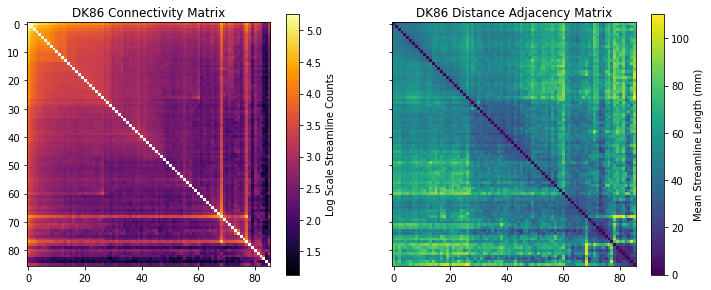

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load matrices:
CM = pd.read_csv('outputs/connectome.csv', header = None)
DM = pd.read_csv('outputs/distances.csv', header = None)

# Visualize:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (12,12))
# log1p - calculates log(1+x)
cdk=ax1.imshow(np.log10(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')
ax1.set_title('DK86 Connectivity Matrix')
cbar=fig.colorbar(cdk, ax=ax1, shrink=0.4)
cbar.set_label('Log Scale Streamline Counts')

ddk=ax2.imshow(DM, interpolation = 'nearest')
ax2.set_title('DK86 Distance Adjacency Matrix')
dbar=fig.colorbar(ddk, ax=ax2, shrink=0.4)
dbar.set_label('Mean Streamline Length (mm)')